In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from sklearn.ensemble import IsolationForest
from tqdm import tqdm

In [2]:
# GPU 사용 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## test 폴더 내 1 이미지 좌우반전 후 train, test로 분리

In [3]:
'''
# train 좌우반전하여 이미지 추가 생성

for i in range(tmp_train_df.shape[0]):
  img_path = tmp_train_df['img_path'].iloc[i]
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  transformed_img = transforms.Compose([transforms.RandomHorizontalFlip(p=1.0)])(torch.tensor(img))
  cv2.imwrite('./train/TRAIN_'+str(213 + i) + '.png', cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
'''

"\n# train 좌우반전하여 이미지 추가 생성\n\nfor i in range(tmp_train_df.shape[0]):\n  img_path = tmp_train_df['img_path'].iloc[i]\n  img = cv2.imread(img_path)\n  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)\n  transformed_img = transforms.Compose([transforms.RandomHorizontalFlip(p=1.0)])(torch.tensor(img))\n  cv2.imwrite('./train/TRAIN_'+str(213 + i) + '.png', cv2.cvtColor(img, cv2.COLOR_BGR2RGB))\n"

In [4]:
%cd C:\Users\user\Documents\ds_study\DL_TeamProject_final\1.data

C:\Users\user\Documents\ds_study\DL_TeamProject_final\1.data


In [5]:
#train 폴더 내 정상 데이터 모두 가져오기
from glob import glob

tmp_train = glob("./train/*.png")
tmp_train = [path.replace('\\', '/') for path in tmp_train]
tmp_train_df = pd.DataFrame({'id': [i.split('/')[2].split('.')[0] for i in tmp_train], 
                             'img_path': tmp_train, 'label': 0}).sort_values(by='img_path', ignore_index=True)

tmp_train_df.tail()

,id,img_path,label
421,TRAIN_421,./train/TRAIN_421.png,0
422,TRAIN_422,./train/TRAIN_422.png,0
423,TRAIN_423,./train/TRAIN_423.png,0
424,TRAIN_424,./train/TRAIN_424.png,0
425,TRAIN_425,./train/TRAIN_425.png,0


In [6]:
# test 폴더 내 정상 데이터 모두 가져오기
tmp_test_df = pd.read_csv('./test_label.csv')
tmp_test_df_all_true = tmp_test_df[tmp_test_df['label'] == 0].reset_index(drop=True)
tmp_test_df_all_true.tail()

,id,img_path,label
56,TEST_084,./test/TEST_084.png,0
57,TEST_087,./test/TEST_087.png,0
58,TEST_089,./test/TEST_089.png,0
59,TEST_096,./test/TEST_096.png,0
60,TEST_097,./test/TEST_097.png,0


In [7]:
# 좌우반전하여 이미지 추가 생성
tmp_df = pd.read_csv('./test_label.csv')
tmp_df_all_false = tmp_test_df[tmp_test_df['label'] == 1].reset_index(drop=True)
tmp_df_all_false.tail()

,id,img_path,label
34,TEST_093,./test/TEST_093.png,1
35,TEST_094,./test/TEST_094.png,1
36,TEST_095,./test/TEST_095.png,1
37,TEST_098,./test/TEST_098.png,1
38,TEST_099,./test/TEST_099.png,1


In [8]:
'''
# test의 1 좌우반전하여 이미지 추가 생성
for i in range(tmp_df_all_false.shape[0]):
  img_path = tmp_df_all_false['img_path'].iloc[i]
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  transformed_img = transforms.Compose([transforms.RandomHorizontalFlip(p=1.0)])(torch.tensor(img))
  cv2.imwrite('./test/TEST_'+str(100 + i) + '.png', cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
'''

"\n# test의 1 좌우반전하여 이미지 추가 생성\nfor i in range(tmp_df_all_false.shape[0]):\n  img_path = tmp_df_all_false['img_path'].iloc[i]\n  img = cv2.imread(img_path)\n  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)\n  transformed_img = transforms.Compose([transforms.RandomHorizontalFlip(p=1.0)])(torch.tensor(img))\n  cv2.imwrite('./test/TEST_'+str(100 + i) + '.png', cv2.cvtColor(img, cv2.COLOR_BGR2RGB))\n"

In [9]:
# 좌우반전된 비정상 데이터만 모두 가져오기
tmp_test = glob("./test/*.png")[100:]
tmp_test = [path.replace('\\', '/') for path in tmp_test]
tmp_test_df = pd.DataFrame({'id' : [i.split('/')[2].split('.')[0] for i in tmp_test] , 
                            'img_path' : tmp_test, 'label' : 1}).sort_values(by='img_path', ignore_index=True)
tmp_test_df.tail()

,id,img_path,label
34,TEST_134,./test/TEST_134.png,1
35,TEST_135,./test/TEST_135.png,1
36,TEST_136,./test/TEST_136.png,1
37,TEST_137,./test/TEST_137.png,1
38,TEST_138,./test/TEST_138.png,1


In [10]:
tmp_test_df.shape

(39, 3)

In [11]:
# 테스트 폴더 내 비정상 데이터들만 합치기
tmp_test_df_all_false = pd.concat([tmp_df_all_false, tmp_test_df], axis=0, sort=True).reset_index(drop=True)
tmp_test_df_all_false = tmp_test_df_all_false.sample(frac=1).reset_index(drop=True)  # shuffling하고 index reset
tmp_test_df_all_false.tail()

,id,img_path,label
73,TEST_104,./test/TEST_104.png,1
74,TEST_090,./test/TEST_090.png,1
75,TEST_113,./test/TEST_113.png,1
76,TEST_107,./test/TEST_107.png,1
77,TEST_024,./test/TEST_024.png,1


In [12]:
# train 폴더 내 정상 이미지
print('train 폴더 내 정상 이미지: ', tmp_train_df.shape)

# test 폴더 내 정상 이미지
print('test 폴더 내 정상 이미지: ', tmp_test_df_all_true.shape)

# test 폴더 내 정상 이미지
print('test 폴더 내 정상 이미지: ', tmp_test_df_all_false.shape)


train 폴더 내 정상 이미지:  (426, 3)
test 폴더 내 정상 이미지:  (61, 3)
test 폴더 내 정상 이미지:  (78, 3)


In [13]:
# train 폴더에 test 1 이미지 분배(5:5)
train_df = pd.concat([tmp_train_df, tmp_test_df_all_false[:39]], axis=0)
train_df = train_df.sample(frac=1).reset_index(drop=True)  # shuffling하고 index reset
train_df

,id,img_path,label
0,TRAIN_149,./train/TRAIN_149.png,0
1,TRAIN_242,./train/TRAIN_242.png,0
2,TRAIN_159,./train/TRAIN_159.png,0
3,TRAIN_219,./train/TRAIN_219.png,0
4,TRAIN_101,./train/TRAIN_101.png,0
...,...,...,...
460,TRAIN_346,./train/TRAIN_346.png,0
461,TRAIN_172,./train/TRAIN_172.png,0
462,TRAIN_143,./train/TRAIN_143.png,0
463,TRAIN_341,./train/TRAIN_341.png,0


In [14]:
# test 폴더에 test 1 이미지 분배(5:5)
test_df = pd.concat([tmp_test_df_all_true, tmp_test_df_all_false[-39:]], axis=0)
test_df = test_df.sample(frac=1).reset_index(drop=True)  # shuffling하고 index reset
test_df

,id,img_path,label
0,TEST_056,./test/TEST_056.png,0
1,TEST_125,./test/TEST_125.png,1
2,TEST_105,./test/TEST_105.png,1
3,TEST_076,./test/TEST_076.png,0
4,TEST_035,./test/TEST_035.png,0
...,...,...,...
95,TEST_062,./test/TEST_062.png,0
96,TEST_111,./test/TEST_111.png,1
97,TEST_129,./test/TEST_129.png,1
98,TEST_028,./test/TEST_028.png,0


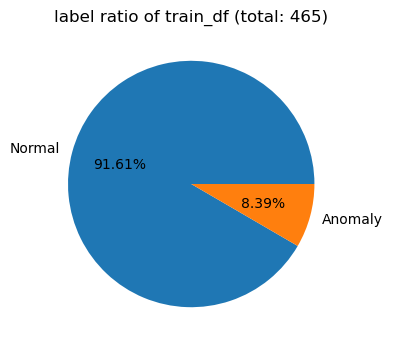

In [15]:
# train 폴더 내 label 비중
import seaborn as sns
labels = ['Normal', 'Anomaly']
plt.figure(figsize=(4, 4))
test_label = train_df.groupby('label').count()
plt.pie(test_label['id'], labels= labels, autopct='%1.2f%%')
plt.title('label ratio of train_df (total: 465)')
plt.show()

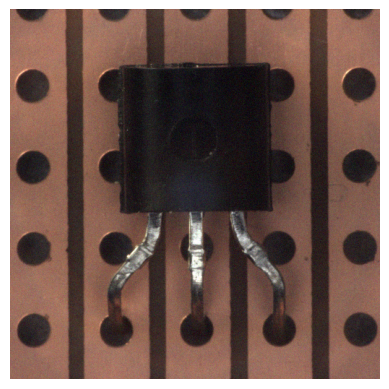

In [16]:
# 이미지 읽기
image = cv2.imread(train_df['img_path'][0])

# BGR에서 RGB로 색 공간 변환
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# 이미지 시각화
plt.imshow(image_rgb)
plt.axis('off')  # 축 제거
plt.show()

In [17]:
def image_array(df):
      img_path = df['img_path']
      img_list = []
      for i in img_path:
        image = cv2.imread(i)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # 이미지를 RGB 형태로 변환
        image = image.reshape(512*512*3)   # oversampling 위해 1차원 배열로 평탄화
        img_list.append(image)

      return img_list

In [18]:
train_df_arrays = image_array(train_df)
len(train_df_arrays)

465

In [19]:
train_df_arrays[0].shape

(786432,)

In [20]:
# train df 속 1 데이터 증강
# 그냥 이미지 데이터 자체로서 oversampling 한 경우

# SMOTE 적용
from imblearn.over_sampling import SMOTE
X_train = train_df_arrays
y_train = train_df['label']

smote = SMOTE(random_state=13)
# 트레인만 oversampling
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

# 얼마나 늘어났는지 확인
len(X_train), len(y_train), len(X_train_over), len(y_train_over)


(465, 465, 852, 852)

(512, 512, 3) <class 'numpy.ndarray'>


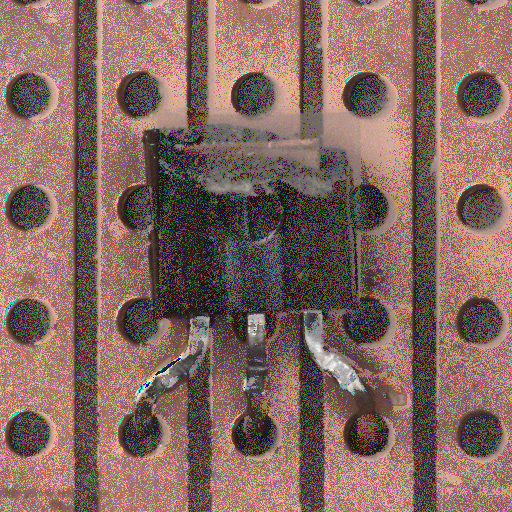

In [21]:
img = np.array(X_train_over[800]).reshape(512, 512, 3)
print(img.shape, type(img))
Image.fromarray(img.astype(np.uint8))


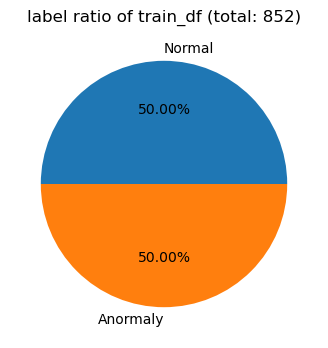

In [22]:
# 증강 후 train 폴더 내 label 비중
import seaborn as sns
labels = ['Normal', 'Anormaly']
plt.figure(figsize=(4, 4))
test_label = [len(X_train_over), len(y_train_over)]
plt.pie(test_label, labels= labels, autopct='%1.2f%%')
plt.title('label ratio of train_df (total: {})'.format(len(y_train_over)))
plt.show()

In [23]:
X_train[0]

array([138,  87,  66, ..., 155, 103,  84], dtype=uint8)

(512, 512, 3) <class 'numpy.ndarray'>


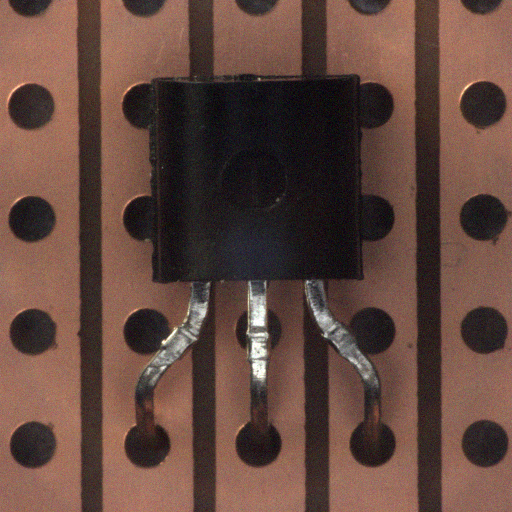

In [24]:
img = np.array(X_train_over[0]).reshape(512, 512, 3)
print(img.shape, type(img))
Image.fromarray(img.astype(np.uint8))

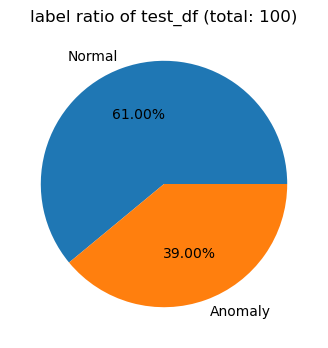

In [25]:
# test 폴더 내 label 비중
import seaborn as sns
labels = ['Normal', 'Anomaly']
plt.figure(figsize=(4, 4))
test_label = test_df.groupby('label').count()
plt.pie(test_label['id'], labels= labels, autopct='%1.2f%%')
plt.title('label ratio of test_df (total: 100)')
plt.show()

## 데이터 로더로 이미지 불러오기

In [26]:
#트레인 데이터 로더로 데이터 불러오기

class TrainCustomDataset(Dataset):
    def __init__(self, xlist, ylist, transform=None):
        super(Dataset, self).__init__()
        self.xlist = xlist
        self.ylist = ylist
        self.transform = transform

    #데이터셋의 길이 출력
    def __len__(self):
        return len(self.xlist)


    #인덱스를 입력하면 해당 인덱스에 해당하는 데이터 샘플을 파싱해서 이미지로 만듦
    def __getitem__(self, idx):
        img_array = self.xlist[idx]
        image = np.array(img_array).reshape(512, 512, 3)   #평탄화한 것 복구
        # ndarray를 이미지로 변환
        image = Image.fromarray(image.astype(np.uint8))
        label = self.ylist[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [27]:
#테스트 데이터 로더로 데이터 불러오기

class TestCustomDataset(Dataset):
    def __init__(self, df, transform=None):
        super(Dataset, self).__init__()
        self.df = df
        self.transform = transform

    #데이터셋의 길이 출력
    def __len__(self):
        return len(self.df)


    #인덱스를 입력하면 해당 인덱스에 해당하는 데이터 샘플을 파싱해서 이미지로 만듦
    def __getitem__(self, idx):
        img_path = self.df['img_path'].iloc[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # ndarray를 이미지로 변환
        image = Image.fromarray(image)
        label = self.df['label'].iloc[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [28]:
# 이미지 전처리 및 임베딩

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [29]:
train_data = TrainCustomDataset(xlist= X_train_over, ylist = y_train_over, transform=transform)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

In [30]:
next(iter(train_loader))

[tensor([[[[ 0.2796,  0.4508,  0.6049,  ...,  0.1254,  0.3138,  0.2796],
           [ 0.3652,  0.4166,  0.5193,  ...,  0.1083,  0.2111,  0.3138],
           [ 0.4679,  0.3823,  0.3823,  ...,  0.1939,  0.2624,  0.2967],
           ...,
           [ 0.4166,  0.4166,  0.3994,  ...,  0.2796,  0.2796,  0.2624],
           [ 0.4166,  0.4851,  0.3823,  ...,  0.1597,  0.1768,  0.2111],
           [ 0.4508,  0.4337,  0.5193,  ...,  0.1768,  0.2624,  0.1768]],
 
          [[-0.2675, -0.1800, -0.1975,  ..., -0.4601, -0.2500, -0.4076],
           [-0.1975, -0.1625, -0.2500,  ..., -0.4426, -0.2850, -0.3025],
           [-0.2150, -0.2500, -0.2675,  ..., -0.3025, -0.2850, -0.2850],
           ...,
           [-0.2675, -0.1450, -0.2150,  ..., -0.3200, -0.3550, -0.3725],
           [-0.2325, -0.1450, -0.2325,  ..., -0.3200, -0.3375, -0.3025],
           [-0.1975, -0.2150, -0.2850,  ..., -0.3550, -0.2675, -0.3025]],
 
          [[-0.1661, -0.1138, -0.2358,  ..., -0.4101, -0.2881, -0.3055],
           [-

In [49]:
test_data = TestCustomDataset(df=test_df, transform=transform)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)

In [54]:
next(iter(test_loader))

[tensor([[[[ 0.2111,  0.2624,  0.3309,  ...,  0.4851,  0.4679,  0.4166],
           [ 0.2796,  0.3652,  0.3309,  ...,  0.4337,  0.4337,  0.4508],
           [ 0.2624,  0.2967,  0.3652,  ...,  0.4679,  0.5193,  0.4508],
           ...,
           [ 0.6563,  0.6049,  0.5364,  ...,  0.2796,  0.2453,  0.1939],
           [ 0.6049,  0.6221,  0.5536,  ...,  0.2453,  0.2453,  0.2453],
           [ 0.5707,  0.5536,  0.6392,  ...,  0.3138,  0.3309,  0.2967]],
 
          [[-0.4601, -0.3550, -0.3375,  ..., -0.2675, -0.2675, -0.2675],
           [-0.3901, -0.3550, -0.3025,  ..., -0.3025, -0.4076, -0.3550],
           [-0.3375, -0.2850, -0.3025,  ..., -0.2850, -0.3025, -0.3550],
           ...,
           [-0.2500, -0.2150, -0.1975,  ..., -0.4076, -0.4076, -0.4426],
           [-0.1450, -0.1450, -0.1625,  ..., -0.3725, -0.4776, -0.4601],
           [-0.1275, -0.1099, -0.1275,  ..., -0.3025, -0.4251, -0.4251]],
 
          [[-0.2707, -0.2010, -0.3404,  ..., -0.3230, -0.2358, -0.3055],
           [-

# 기본 모델링

In [33]:
import torch # 파이토치
import random
import numpy as np
import os

In [34]:
%cd C:\Users\user\Documents\ds_study\DL_TeamProject_final

C:\Users\user\Documents\ds_study\DL_TeamProject_final


In [35]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

- 모델 생성

In [36]:
!pip install efficientnet-pytorch==0.7.1

In [37]:
from efficientnet_pytorch import EfficientNet
# 모델 생성
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=2)
# 장비 할당
model = model.to(device)

Loaded pretrained weights for efficientnet-b0


In [38]:
print('모델 파라미터 개수 :', sum(param.numel() for param in model.parameters()))

모델 파라미터 개수 : 4010110


- 모델 훈련 및 성능검증

In [39]:
#손실 함수와 옵티마이저 설정

import torch.nn as nn

criterion = nn.CrossEntropyLoss()

In [40]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [41]:
#훈련 함수 설정

from sklearn.metrics import accuracy_score # 정확도 계산 함수
from sklearn.metrics import recall_score   # 재현율 계산 함수
from sklearn.metrics import f1_score       # F1 점수 계산 함수
from tqdm.notebook import tqdm             # 진행률 표시 막대

def train(model, loader_train, criterion, optimizer, scheduler=None, epochs=10, save_file='model_state_dict.pth'):

    train_loss_min = np.inf # 최소 손실값 초기화 (검증 데이터용)

    # 총 에폭만큼 반복
    for epoch in range(epochs):
        print(f'에폭 [{epoch+1}/{epochs}] \n-----------------------------')

        # == [ 훈련 ] ==============================================
        model.train()        # 모델을 훈련 상태로 설정
        epoch_train_loss = 0 # 에폭별 손실값 초기화 (훈련 데이터용)
        # '반복 횟수'만큼 반복
        for images, labels in tqdm(loader_train):
            # 이미지, 레이블(타깃값) 데이터 미니배치를 장비에 할당
            images = images.to(device)
            labels = labels.to(device)

            # 옵티마이저 내 기울기 초기화
            optimizer.zero_grad()
            # 순전파 : 이미지 데이터를 신경망 모델의 입력값으로 사용해 출력값 계산
            outputs = model(images)
            # 손실 함수를 활용해 outputs와 labels의 손실값 계산
            loss = criterion(outputs, labels)
            # 현재 배치에서의 손실 추가 (훈련 데이터용)
            epoch_train_loss += loss.item()
            loss.backward()       # 역전파 수행
            optimizer.step()      # 가중치 갱신
            if scheduler != None: # 스케줄러 학습률 갱신
                scheduler.step()

        # 훈련 데이터 손실값 출력
        print(f'\t batch당 훈련 데이터 손실값 평균 : {epoch_train_loss/len(loader_train):.4f}')
        # == [ 최적 모델 가중치 찾기 ] ==============================
        # 현 에폭에서의 손실값이 최소 손실값 이하면 모델 가중치 저장
        if epoch_train_loss <= train_loss_min:
            print(f'\t### 훈련 데이터 손실값 감소 ({train_loss_min:.4f} --> {epoch_train_loss:.4f}). 모델 저장')
            # 모델 가중치를 파일로 저장
            torch.save(model.state_dict(), save_file)
            train_loss_min = epoch_train_loss # 최소 손실값 갱신
    return torch.load(save_file) # 저장한 모델 가중치를 불러와 반환

In [42]:
model_state_dict = train(model=model,
                         loader_train=train_loader,
                         criterion=criterion,
                         optimizer=optimizer)

에폭 [1/10] 
-----------------------------


  0%|          | 0/27 [00:00<?, ?it/s]

	 batch당 훈련 데이터 손실값 평균 : 0.4132
	### 훈련 데이터 손실값 감소 (inf --> 11.1555). 모델 저장
에폭 [2/10] 
-----------------------------


  0%|          | 0/27 [00:00<?, ?it/s]

	 batch당 훈련 데이터 손실값 평균 : 0.3152
	### 훈련 데이터 손실값 감소 (11.1555 --> 8.5098). 모델 저장
에폭 [3/10] 
-----------------------------


  0%|          | 0/27 [00:00<?, ?it/s]

	 batch당 훈련 데이터 손실값 평균 : 0.1215
	### 훈련 데이터 손실값 감소 (8.5098 --> 3.2806). 모델 저장
에폭 [4/10] 
-----------------------------


  0%|          | 0/27 [00:00<?, ?it/s]

	 batch당 훈련 데이터 손실값 평균 : 0.1116
	### 훈련 데이터 손실값 감소 (3.2806 --> 3.0143). 모델 저장
에폭 [5/10] 
-----------------------------


  0%|          | 0/27 [00:00<?, ?it/s]

	 batch당 훈련 데이터 손실값 평균 : 0.0962
	### 훈련 데이터 손실값 감소 (3.0143 --> 2.5963). 모델 저장
에폭 [6/10] 
-----------------------------


  0%|          | 0/27 [00:00<?, ?it/s]

	 batch당 훈련 데이터 손실값 평균 : 0.0198
	### 훈련 데이터 손실값 감소 (2.5963 --> 0.5337). 모델 저장
에폭 [7/10] 
-----------------------------


  0%|          | 0/27 [00:00<?, ?it/s]

	 batch당 훈련 데이터 손실값 평균 : 0.0090
	### 훈련 데이터 손실값 감소 (0.5337 --> 0.2433). 모델 저장
에폭 [8/10] 
-----------------------------


  0%|          | 0/27 [00:00<?, ?it/s]

	 batch당 훈련 데이터 손실값 평균 : 0.0027
	### 훈련 데이터 손실값 감소 (0.2433 --> 0.0716). 모델 저장
에폭 [9/10] 
-----------------------------


  0%|          | 0/27 [00:00<?, ?it/s]

	 batch당 훈련 데이터 손실값 평균 : 0.0052
에폭 [10/10] 
-----------------------------


  0%|          | 0/27 [00:00<?, ?it/s]

	 batch당 훈련 데이터 손실값 평균 : 0.0040


In [43]:
# 최적 가중치 불러오기
model.load_state_dict(model_state_dict)

<All keys matched successfully>

# 예측 및 평가 결과

- 예측

In [51]:
%cd C:\Users\user\Documents\ds_study\DL_TeamProject_final\1.data

C:\Users\user\Documents\ds_study\DL_TeamProject_final\1.data


In [52]:
def predict(model, loader_test, return_true=False):
    model.eval()    # 모델을 평가 상태로 설정
    preds_list = [] # 예측값 저장용 리스트 초기화
    true_list = []  # 실제값 저장용 리스트 초기화

    with torch.no_grad(): # 기울기 계산 비활성
        for images, labels in loader_test:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)

            preds = torch.max(outputs.cpu(), dim=1)[1].numpy() # 예측값
            true = labels.cpu().numpy() # 실제값

            preds_list.extend(preds)
            true_list.extend(true)

    if return_true:
        return true_list, preds_list
    else:
        return preds_list

In [53]:
true_list, preds_list = predict(model=model,
                                loader_test=test_loader,
                                return_true=True)

- 평가 결과

In [55]:
from sklearn.metrics import accuracy_score, precision_score , recall_score , confusion_matrix

print('#'*5, '최종 예측 결과 평가 점수', '#'*5)
print(f'정확도 : {accuracy_score(true_list, preds_list):.4f}')
print(f'재현율 : {recall_score(true_list, preds_list):.4f}')
print(f'F1 점수 : {f1_score(true_list, preds_list):.4f}')
print(f'정밀도 : {precision_score(true_list, preds_list):.4f}')

##### 최종 예측 결과 평가 점수 #####
정확도 : 0.8000
재현율 : 0.8974
F1 점수 : 0.7778
정밀도 : 0.6863


In [56]:
confusion_matrix(true_list, preds_list)

array([[45, 16],
       [ 4, 35]], dtype=int64)

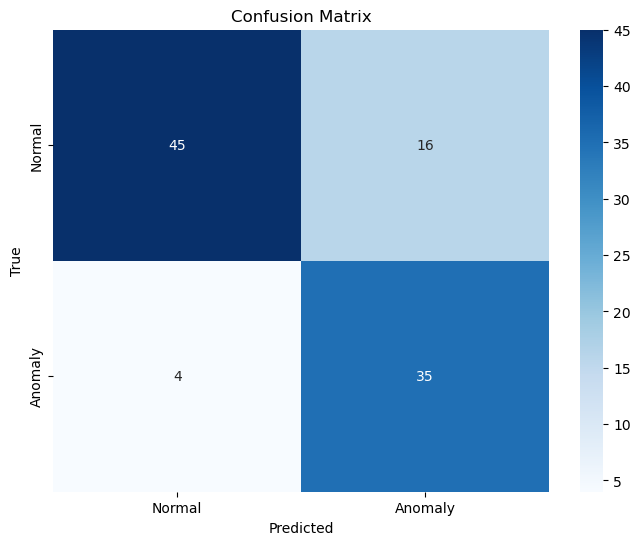

In [57]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix 계산
cm = confusion_matrix(true_list, preds_list)

# Confusion Matrix 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

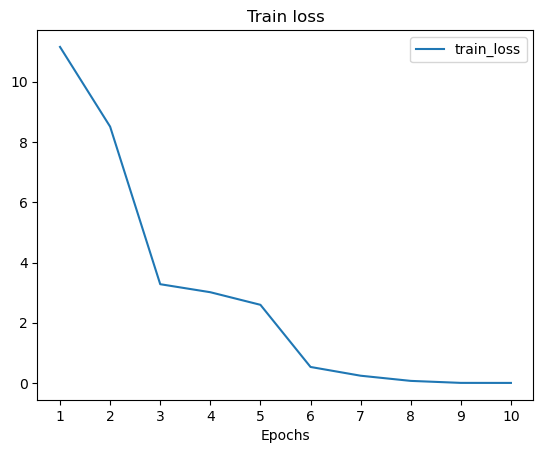

In [61]:
train_loss = [11.1555, 8.5098, 3.2806, 3.0143, 2.5963, 0.5337, 0.2433, 0.0716, 0.0052, 0.0040]

fig = plt.figure()
fig.set_facecolor('white')
sns.lineplot(x = range(1, 11), y=train_loss, label='train_loss') 
plt.xticks(range(1, 11))
plt.title('Train loss')
plt.xlabel('Epochs');
